In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from utils import eq_covariance,              \
                  sample_datasets_from_gps,   \
                  gp_post_pred,               \
                  plot_sample_and_predictions

# Sample and plot a few datapoints

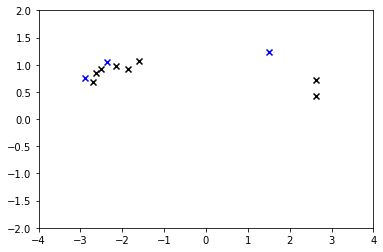

In [2]:
num_batches = 1
num_train = 8
num_test = 3
lengthscale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = False

train_data, test_data = sample_datasets_from_gps(num_batches,
                                                 num_train,
                                                 num_test,
                                                 lengthscale,
                                                 cov_coeff,
                                                 noise_coeff,
                                                 as_tensor)

plt.scatter(train_data[0][0], train_data[1][0], marker='x', color='black')
plt.scatter(test_data[0][0], test_data[1][0], marker='x', color='blue')

plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.show()

# CNP definition

In [3]:
class FeedforwardNetwork(nn.Module):
    
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 nums_hidden,
                 nonlinearity):
        
        super().__init__()
        
        sizes = [input_dim] + nums_hidden + [output_dim]
        sizes = [(s1, s2) for s1, s2 in zip(sizes[:-1], sizes[1:])]
        
        self.linear = [nn.Linear(s1, s2, bias=True) for s1, s2 in sizes]
        self.linear = nn.ModuleList(self.linear)
        
        self.nonlinearity = getattr(nn, nonlinearity)()
        
    
    def forward(self, tensor):
        
        for linear in self.linear[:-1]:
            
            tensor = linear(tensor)
            tensor = self.nonlinearity(tensor)
            
        tensor = self.linear[-1](tensor)
        
        return tensor
    
    
class ConditionalNeuralProcess(nn.Module):
    
    def __init__(self,
                 cond_lik,
                 encoder):
        
        
        super().__init__()
        
        self.cond_lik = cond_lik
        self.encoder = encoder
        
        self.normal = torch.distributions.Normal
        
        
    def forward(self,
                context_inputs,
                context_outputs,
                target_inputs):
        
        context_inputs = context_inputs.unsqueeze(dim=-1)
        context_outputs = context_outputs.unsqueeze(dim=-1)
        target_inputs = target_inputs.unsqueeze(dim=-1)
        
        context = torch.cat([context_inputs, context_outputs], dim=-1)
        
        theta = self.encoder(context)
        theta = torch.mean(theta, dim=1)[:, None, :]
        theta = theta.repeat(1, target_inputs.shape[1], 1)
        
        tensor = torch.cat([target_inputs, theta], dim=-1)
        
        tensor = self.cond_lik(tensor)
        tensor = torch.reshape(tensor, tensor.shape[:2] + (-1, 2))
        
        mean, log_stdev = tensor[:, :, :, 0], tensor[:, :, :, 1]
        
        return mean, log_stdev
    
    
    def _loss(self,
              context_inputs,
              context_outputs,
              target_inputs,
              target_outputs):
        
        target_outputs = target_outputs.unsqueeze(dim=-1)
        
        mean, log_stdev = self.forward(context_inputs,
                                       context_outputs,
                                       target_inputs)
        
        stdev = torch.exp(log_stdev)
        
        cond_dist = self.normal(loc=mean, scale=stdev)
        
        log_prob = cond_dist.log_prob(target_outputs)
        
        log_prob = torch.mean(log_prob, dim=0)
        log_prob = torch.sum(log_prob)
        
        return - log_prob
    
    
    def loss(self,
             inputs,
             outputs,
             num_samples):
        
        loss = 0
        
        for i in range(num_samples):
            
            N = np.random.choice(np.arange(1, inputs.shape[1]))
            
            context_inputs = inputs[:, :N]
            context_outputs = outputs[:, :N]
            target_inputs = inputs[:, N:]
            target_outputs = outputs[:, N:]
            
            loss = loss + self._loss(context_inputs,
                                     context_outputs,
                                     target_inputs,
                                     target_outputs)
        
        loss = loss / num_samples
        
        return loss

# All aboard the training train choooo choooo!!!

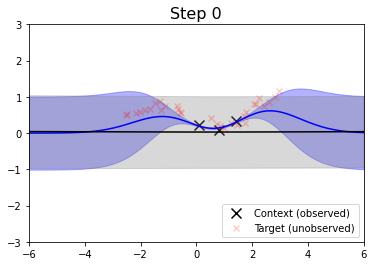

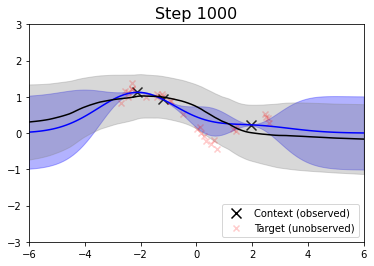

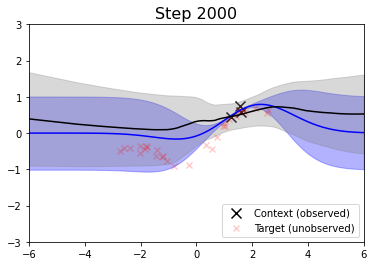

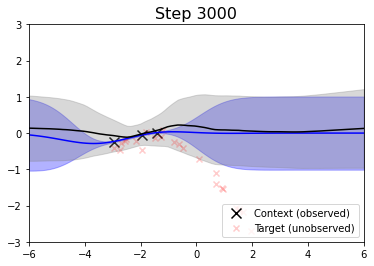

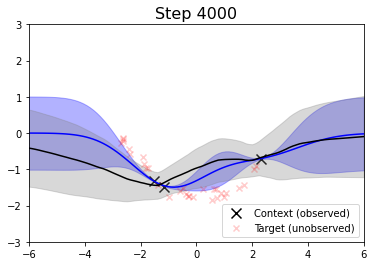

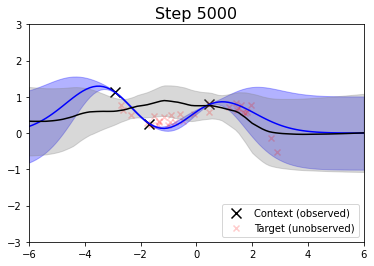

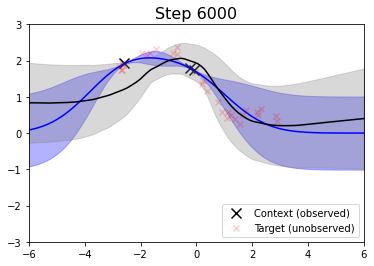

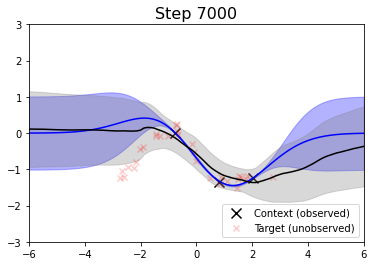

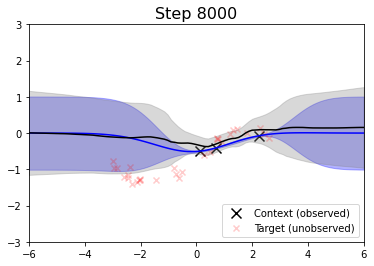

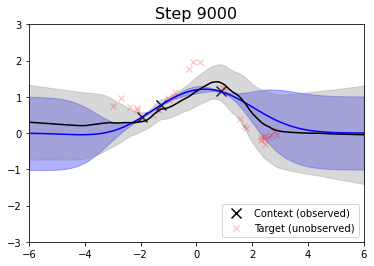

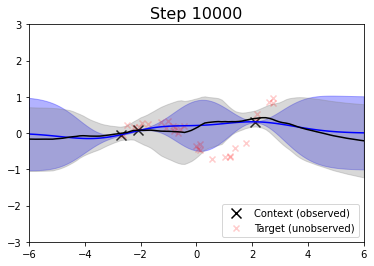

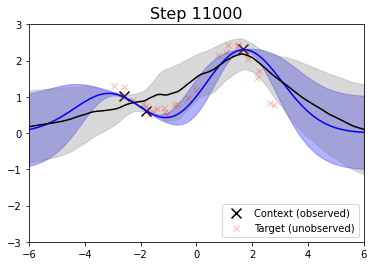

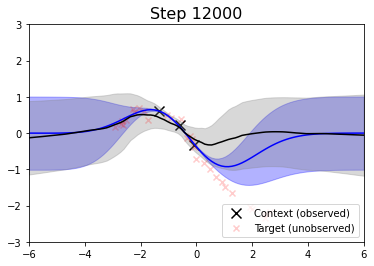

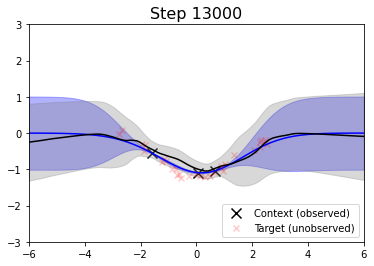

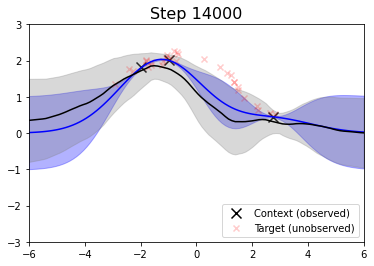

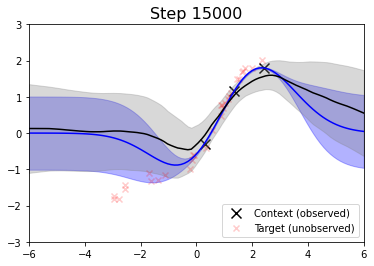

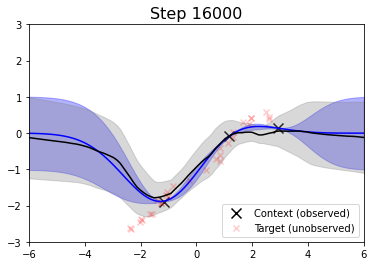

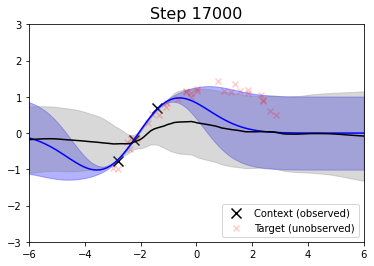

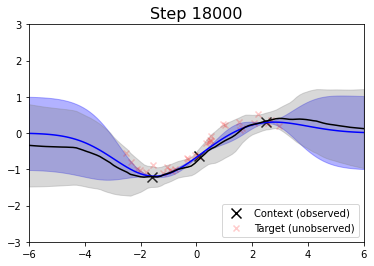

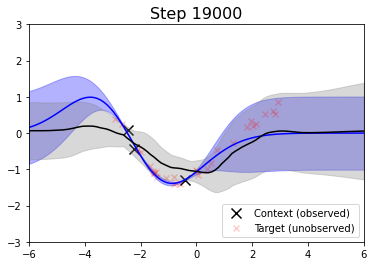

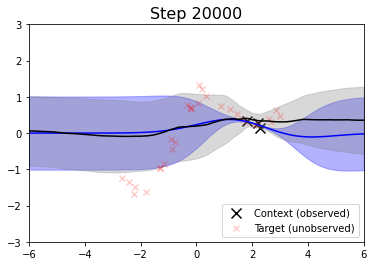

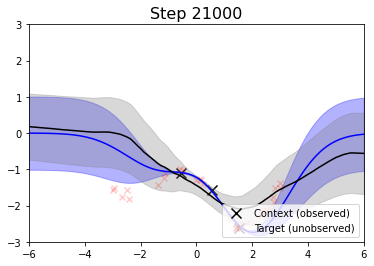

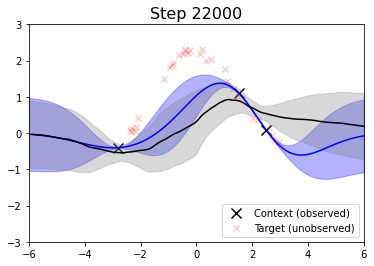

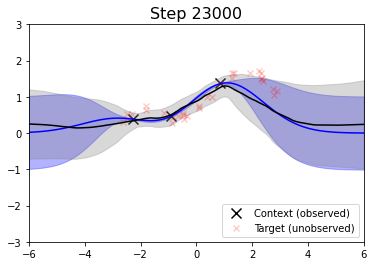

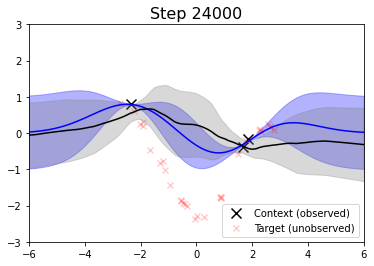

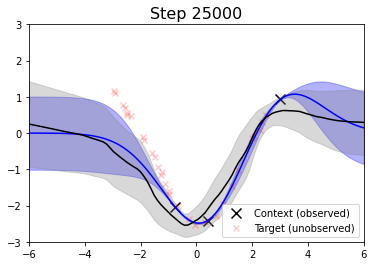

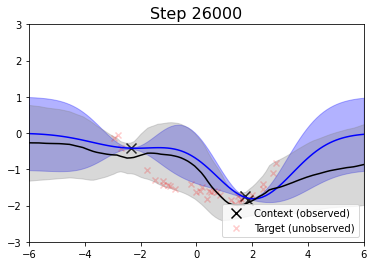

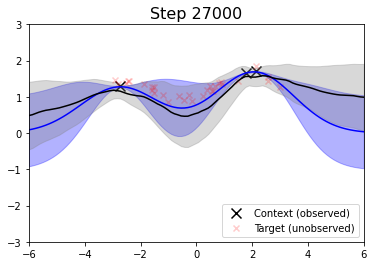

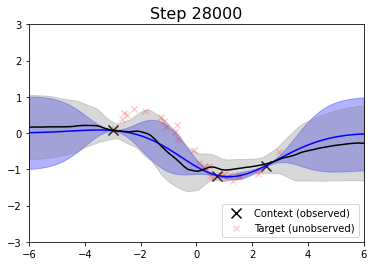

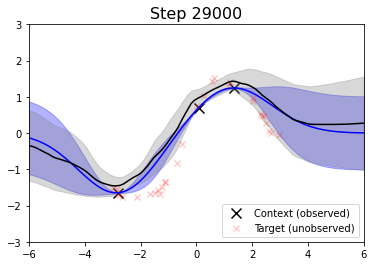

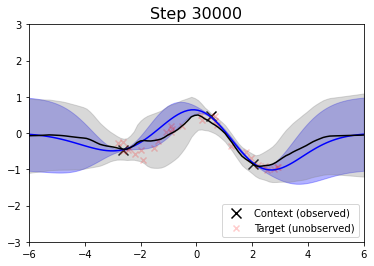

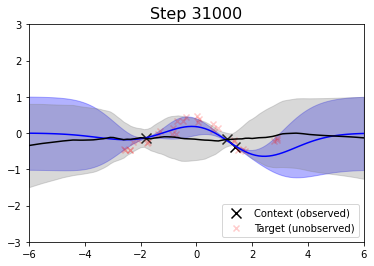

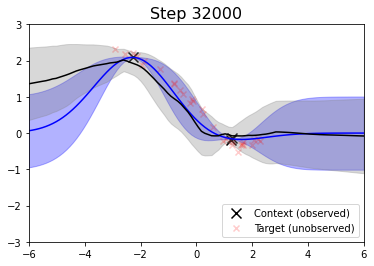

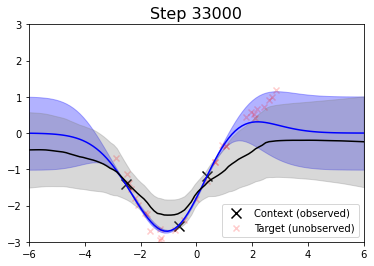

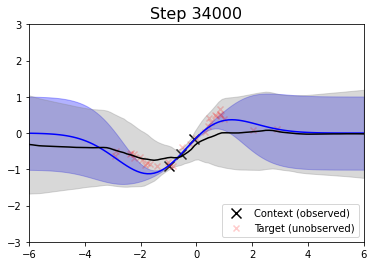

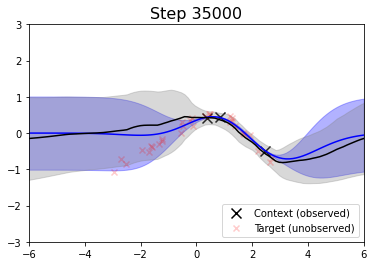

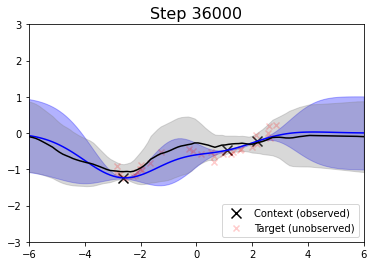

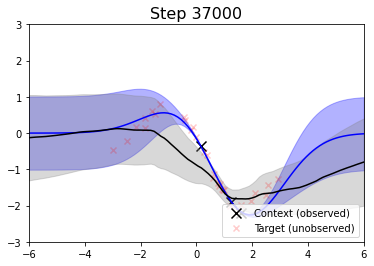

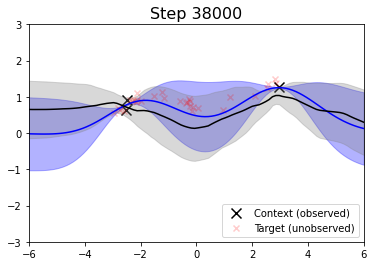

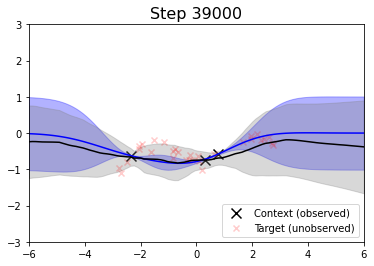

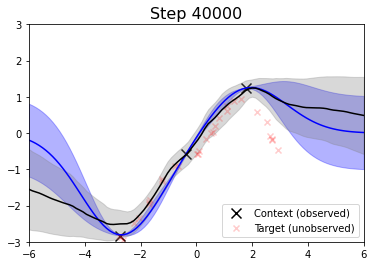

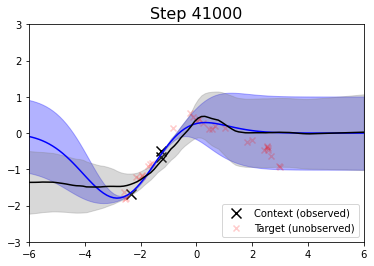

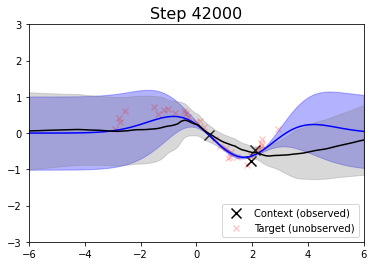

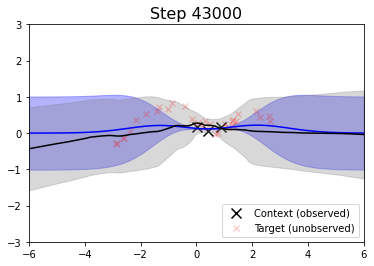

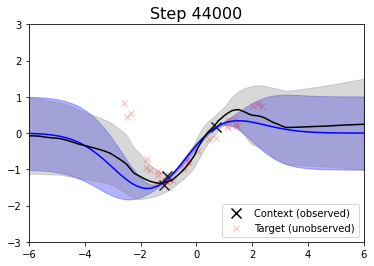

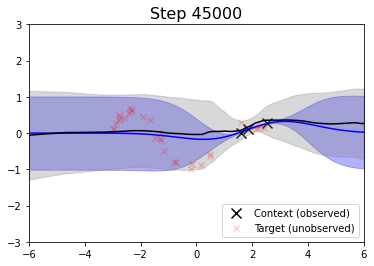

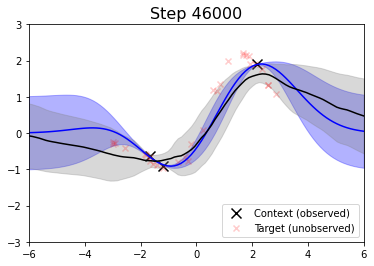

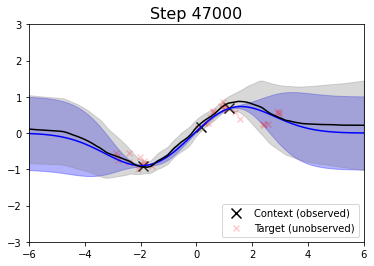

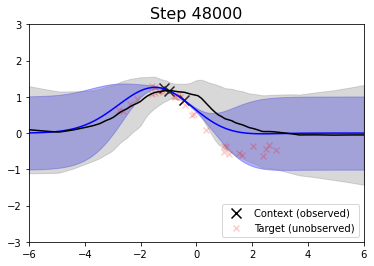

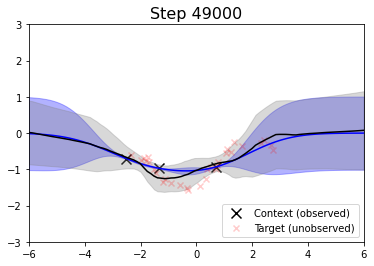

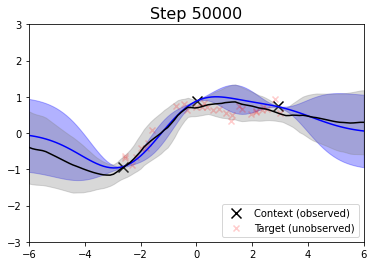

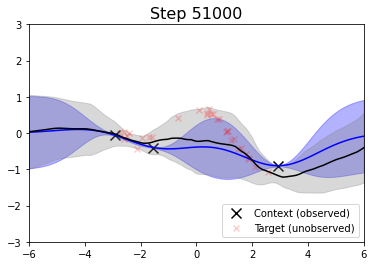

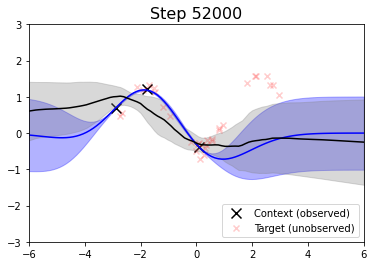

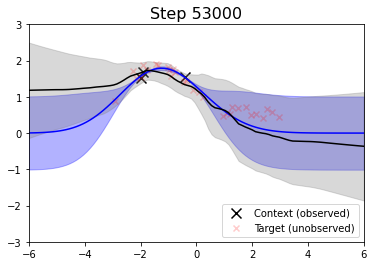

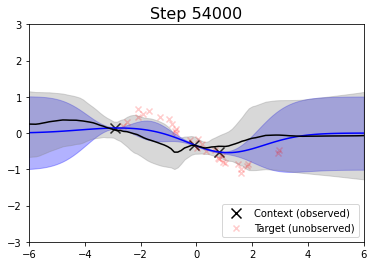

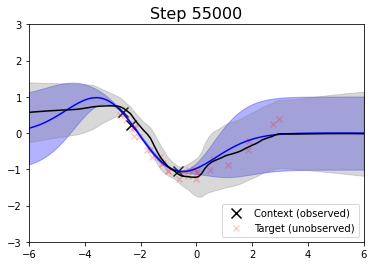

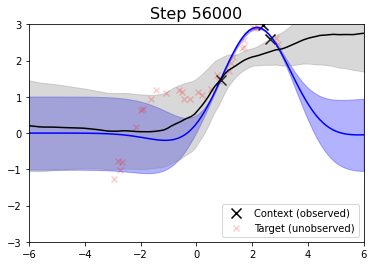

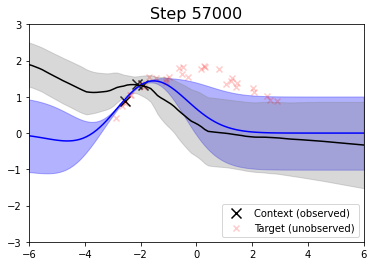

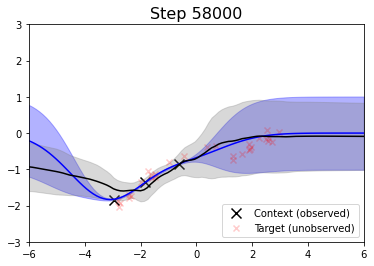

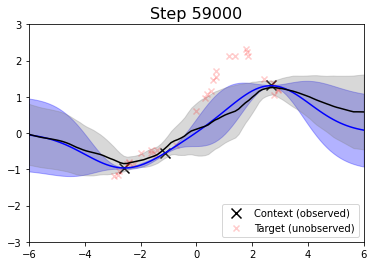

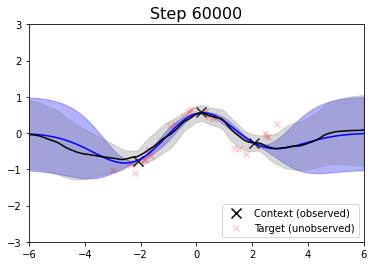

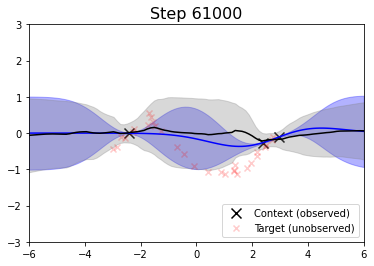

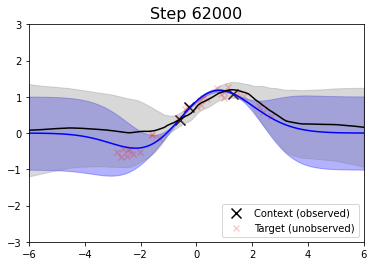

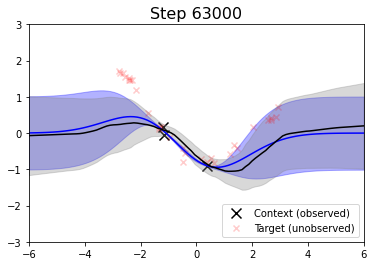

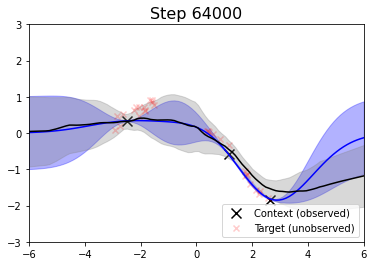

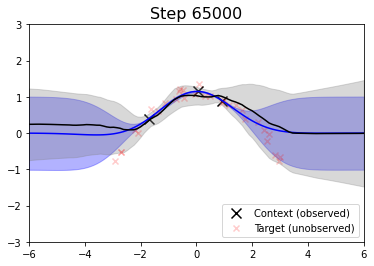

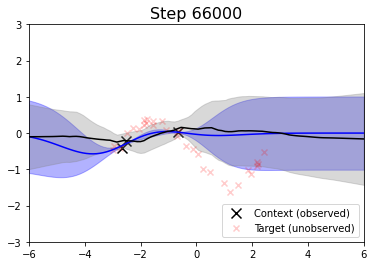

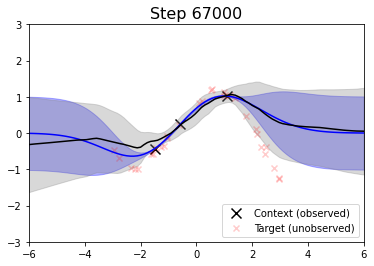

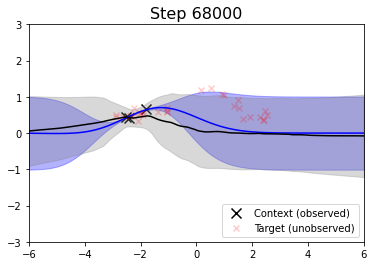

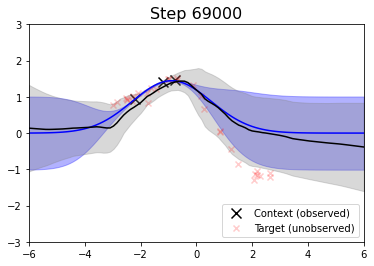

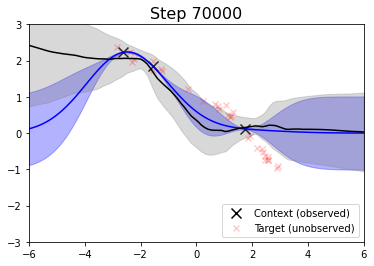

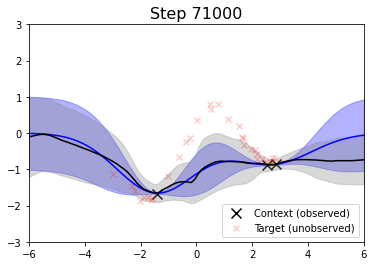

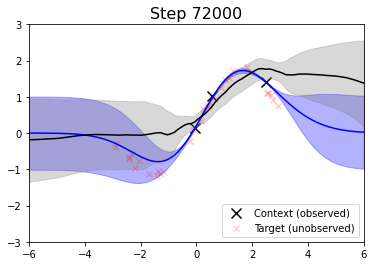

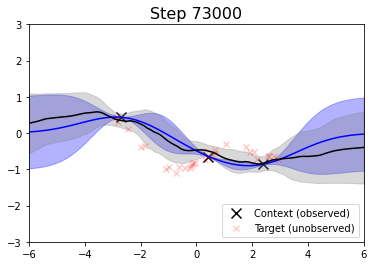

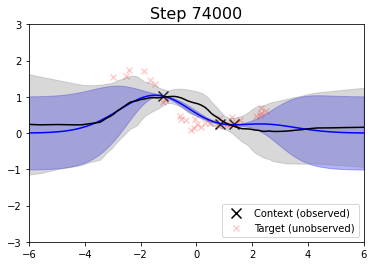

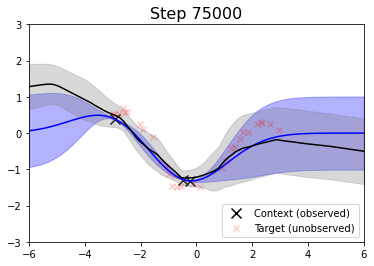

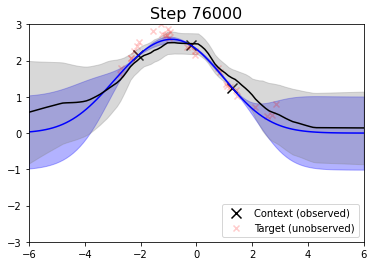

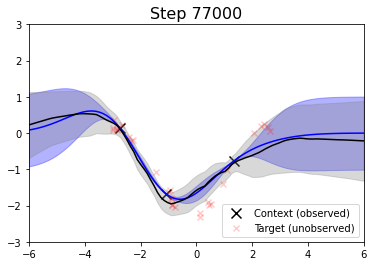

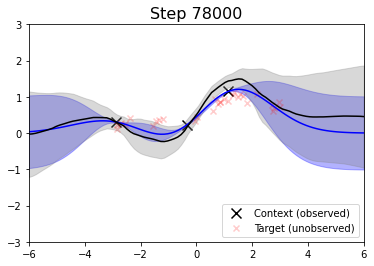

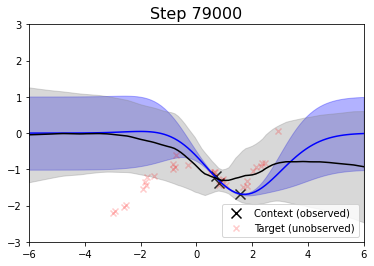

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/stratis/Documents/research/conditional-neural-processes/venv-cnp/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-245cf552eefa>", line 48, in <module>
    optimizer.step()
  File "/Users/stratis/Documents/research/conditional-neural-processes/venv-cnp/lib/python3.7/site-packages/torch/optim/adam.py", line 96, in step
    exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/stratis/Documents/research/conditional-neural-processes/venv-cnp/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, ano

KeyboardInterrupt: 

In [4]:
# Dataset parameters
batch_size = 20
num_train = 6
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
plot_input_range = (-6., 6.)

# Training parameters and optimizer
num_train_steps = int(1e5)
lr = 1e-3

cond_lik = FeedforwardNetwork(input_dim=129,
                              output_dim=2,
                              nums_hidden=[128, 128, 128, 128],
                              nonlinearity='ReLU')

encoder = FeedforwardNetwork(input_dim=2,
                             output_dim=128,
                             nums_hidden=[128, 128],
                             nonlinearity='ReLU')

conditional_neural_process = ConditionalNeuralProcess(cond_lik=cond_lik,
                                                      encoder=encoder)

optimizer = torch.optim.Adam(conditional_neural_process.parameters(), lr=lr)

losses = []

for i in range(num_train_steps):
    
    train_data, test_data = sample_datasets_from_gps(batch_size,
                                                     num_train,
                                                     num_test,
                                                     scale,
                                                     cov_coeff,
                                                     noise_coeff,
                                                     as_tensor)
    
    inputs, outputs = train_data
    
    loss = conditional_neural_process.loss(inputs, outputs, num_samples=1)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 1e3 == 0:
        
        plot_sample_and_predictions(conditional_neural_process,
                                    input_range=plot_input_range,
                                    num_train=3,
                                    num_test=30,
                                    scale=scale,
                                    cov_coeff=cov_coeff,
                                    noise_coeff=noise_coeff,
                                    step=i,
                                    plot_test_data=True)